<a href="https://colab.research.google.com/github/yash722/Wound-Assessment/blob/main/WoundDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Nico-Curti/Deepskin.git
%cd Deepskin

Cloning into 'Deepskin'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 217 (delta 105), reused 163 (delta 54), pack-reused 0
Receiving objects: 100% (217/217), 4.18 MiB | 36.86 MiB/s, done.
Resolving deltas: 100% (105/105), done.
/content/Deepskin


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 26.4 MB/s eta 0:00:00


In [ ]:
!python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.models as models
import os
from PIL import Image
import cv2
# from deepskin import wound_segmentation

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# **Dataset information:**


* AZH dataset is collected over a two-year clinical period at the AZH Wound and Vascular Center in Milwaukee, Wisconsin. The dataset includes 730 wound images in .jpg format. The images are of various sizes, where the width ranging from 320 to 700 pixels and the height ranging from 240 to 525 pixels.

* These images contain four different wound types: venous, diabetic, pressure, and surgical. iPad Pro (software version 13.4.1) and a Canon SX 620 HS digital camera are used to capture the images, and labeling is done by a wound specialist from the AZH Wound and Vascular Center.

Research - [https://www.nature.com/articles/s41598-022-21813-0](https://www.nature.com/articles/s41598-022-21813-0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# wound_image = "/content/drive/MyDrive/Train/V/101_0.jpg"
# wound_thermal_image = "/content/FLIR1262.jpg"

In [ ]:
# def get_wound_segmentation_image(image_path):
#   image = cv2.imread(image_path)
#   print(image.shape)
#   actual_wound = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   mask = wound_segmentation(img=actual_wound)

#   # plt.figure(figsize=(10, 10))
#   # plt.imshow(binary_mask, cmap='gray')
#   # plt.title('Binary Mask')
#   # plt.axis('off')
#   # plt.show()

#   lower_red = np.array([255, 0, 0])
#   upper_red = np.array([255, 0, 0])
#   binary_mask = cv2.inRange(mask, lower_red, upper_red)
#   contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#   x_min, y_min = float('inf'), float('inf')
#   x_max, y_max = float('-inf'), float('-inf')

#   for contour in contours:
#       x, y, w, h = cv2.boundingRect(contour)
#       x_min = min(x_min, x)
#       y_min = min(y_min, y)
#       x_max = max(x_max, x + w)
#       y_max = max(y_max, y + h)

#   margin = 0
#   x_min = max(0, x_min + margin)
#   y_min = max(0, y_min + margin)
#   x_max = min(image.shape[1], x_max - margin)
#   y_max = min(image.shape[0], y_max - margin)

#   output_image = image.copy()
#   cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (0, 0, 0), 2)

#   plt.figure(figsize=(10, 10))
#   plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
#   plt.title('Bounding Box on Original Image')
#   plt.axis('off')
#   plt.show()

In [ ]:
# get_wound_segmentation_image(wound_image)

In [ ]:
# get_wound_segmentation_image(wound_thermal_image)

In [ ]:
def show_img(output_image, thermal = False):
    plt.figure(figsize=(10, 10))
    if thermal:
      plt.imshow(output_image, cmap='inferno')
    else:
      plt.imshow(output_image)
    plt.axis('off')
    plt.show()

In [ ]:
train_directory = '/content/drive/My Drive/train'

In [ ]:
# labels = pd.read_csv(f'{train_directory}/wound_locations_Labels_AZH_Train.csv')
# labels[labels['Labels'] == 4].tail(10)

In [ ]:
def list_subfolders(directory):
    subfolders = [f.name for f in os.scandir(directory) if f.is_dir()]
    return subfolders

subfolders = list_subfolders(train_directory)
subfolders = subfolders[:-1]
subfolders

['skin tears', 'burns', 'venous', 'trauma', 'DFU', 'pressure ulcer', 'normal']

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            img = transform(img)
            images.append(img)
    return images

In [ ]:
train_images = []
for s in subfolders:
  s_path = train_directory + '/' + s
  images_tensor = load_images_from_folder(s_path)
  train_images.append(images_tensor)

label = []
for i in range(len(train_images)):
  for j in range(len(train_images[i])):
    label.append(i)

In [ ]:
label = torch.tensor(label)

In [ ]:
len(train_images[0]), len(train_images[1]), len(train_images[2]), len(train_images[3]), len(train_images[4]), len(train_images[5]), len(train_images[6])

(54, 377, 468, 101, 329, 384, 100)

Label Annotation -
*   'venous' - 0
*   'trauma' - 1
*   'surgical' - 2
*   'skin tears' - 3
*   'pressure ulcer' - 4
*   'normal' - 5
*   'DFU' - 6
*   'burns' - 7

In [ ]:
label.shape

torch.Size([1813])

In [ ]:
stacked_tensor0 = torch.stack(train_images[0])
stacked_tensor1 = torch.stack(train_images[1])
stacked_tensor2 = torch.stack(train_images[2])
stacked_tensor3 = torch.stack(train_images[3])
stacked_tensor4 = torch.stack(train_images[4])
stacked_tensor5 = torch.stack(train_images[5])
stacked_tensor6 = torch.stack(train_images[6])
# stacked_tensor7 = torch.stack(train_images[7])

dataset_images = torch.cat((stacked_tensor0, stacked_tensor1, stacked_tensor2,
                                  stacked_tensor3, stacked_tensor4, stacked_tensor5,
                                  stacked_tensor6), dim=0)

In [ ]:
dataset_images.shape, label.shape

(torch.Size([1813, 3, 224, 224]), torch.Size([1813]))

In [ ]:
dataset = TensorDataset(dataset_images, label)

In [ ]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Initially used basic RGB images with a pretrained ResNet50 model. This model is finetuned according to the training dataset.

In [ ]:
def initialize_model():
  model = models.vit_b_16(pretrained=True)
  model.heads = nn.Linear(model.heads.head.in_features, 7)
  model_ft = nn.Sequential(
      model,
      nn.LogSoftmax(dim=1)
  )
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
  return model_ft, criterion, optimizer

In [ ]:
def train_model(model, train_loader, optimizer, criterion, num_epochs):
  model.train()
  model = model.to(device)
  for epoch in range(num_epochs):
      model.train()
      total_loss = 0
      progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}')
      for batch_idx, (inputs, labels) in progress_bar:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          progress_bar.set_postfix({'loss': total_loss/(batch_idx+1)})
      print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

  return model

In [ ]:
def evaluate_model(model, val_loader, criterion):
  model.eval()
  model = model.to(device)
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Evaluating Model', leave=True):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print(f'Accuracy of the model on the test images: {100 * correct / total}%')

In [ ]:
vis_model_ft, criterion, optimizer = initialize_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
trained_vis_transformer = train_model(vis_model_ft, train_loader, optimizer, criterion, num_epochs=100)

Epoch 1/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/100, Loss: 1.3218670604021654


Epoch 2/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2/100, Loss: 0.7634308435346769


Epoch 3/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3/100, Loss: 0.5031138859365297


Epoch 4/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4/100, Loss: 0.2910242070970328


Epoch 5/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5/100, Loss: 0.15545100524373676


Epoch 6/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6/100, Loss: 0.08205012078194515


Epoch 7/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7/100, Loss: 0.047993674307413726


Epoch 8/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8/100, Loss: 0.03149765051658387


Epoch 9/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9/100, Loss: 0.02205170419715021


Epoch 10/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/100, Loss: 0.017206781650083543


Epoch 11/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11/100, Loss: 0.015040918427985162


Epoch 12/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12/100, Loss: 0.014122687664854786


Epoch 13/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13/100, Loss: 0.013095499102390655


Epoch 14/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14/100, Loss: 0.011201389655268387


Epoch 15/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15/100, Loss: 0.010422435158904156


Epoch 16/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 16/100, Loss: 0.010394756378524977


Epoch 17/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 17/100, Loss: 0.009024764709782017


Epoch 18/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 18/100, Loss: 0.009477636533910814


Epoch 19/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 19/100, Loss: 0.008260659519178063


Epoch 20/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 20/100, Loss: 0.007821832697474114


Epoch 21/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 21/100, Loss: 0.0077147368726361056


Epoch 22/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 22/100, Loss: 0.007167116994463393


Epoch 23/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 23/100, Loss: 0.0070717201072155785


Epoch 24/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 24/100, Loss: 0.006862619545047536


Epoch 25/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 25/100, Loss: 0.007321440799505976


Epoch 26/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 26/100, Loss: 0.006360861685369973


Epoch 27/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 27/100, Loss: 0.006263703598802828


Epoch 28/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 28/100, Loss: 0.006244066637009382


Epoch 29/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 29/100, Loss: 0.006433259184553247


Epoch 30/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 30/100, Loss: 0.005342696761742801


Epoch 31/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 31/100, Loss: 0.005549035720911849


Epoch 32/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 32/100, Loss: 0.005558240753800973


Epoch 33/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 33/100, Loss: 0.005731046731259836


Epoch 34/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 34/100, Loss: 0.00521218200193961


Epoch 35/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 35/100, Loss: 0.005509166783430492


Epoch 36/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 36/100, Loss: 0.005175809963079898


Epoch 37/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 37/100, Loss: 0.005496658332919216


Epoch 38/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 38/100, Loss: 0.005169722211101781


Epoch 39/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 39/100, Loss: 0.005479808146407342


Epoch 40/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 40/100, Loss: 0.004784620918697961


Epoch 41/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 41/100, Loss: 0.00493060036324491


Epoch 42/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 42/100, Loss: 0.005194959029524952


Epoch 43/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 43/100, Loss: 0.0049751592210352255


Epoch 44/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 44/100, Loss: 0.0056982787918177956


Epoch 45/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 45/100, Loss: 0.005464107118946824


Epoch 46/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 46/100, Loss: 0.004581773674505277


Epoch 47/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 47/100, Loss: 0.0043142808629098636


Epoch 48/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 48/100, Loss: 0.004367435283948789


Epoch 49/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 49/100, Loss: 0.004955789528574552


Epoch 50/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 50/100, Loss: 0.004509939791877632


Epoch 51/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 51/100, Loss: 0.00480676738104945


Epoch 52/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 52/100, Loss: 0.00480753099027029


Epoch 53/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 53/100, Loss: 0.004635324103140231


Epoch 54/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 54/100, Loss: 0.004257364675615226


Epoch 55/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 55/100, Loss: 0.00449725913273616


Epoch 56/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 56/100, Loss: 0.004472686181543395


Epoch 57/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 57/100, Loss: 0.0044148529717779675


Epoch 58/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 58/100, Loss: 0.0042939377586741975


Epoch 59/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 59/100, Loss: 0.004182425061235731


Epoch 60/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 60/100, Loss: 0.004905865902875793


Epoch 61/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 61/100, Loss: 0.004848886347051872


Epoch 62/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 62/100, Loss: 0.004164381887201908


Epoch 63/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 63/100, Loss: 0.0043857998307035104


Epoch 64/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 64/100, Loss: 0.004066633616078078


Epoch 65/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 65/100, Loss: 0.003985032222218528


Epoch 66/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 66/100, Loss: 0.005441913423609272


Epoch 67/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 67/100, Loss: 0.004978291122192193


Epoch 68/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 68/100, Loss: 0.004564064626997013


Epoch 69/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 69/100, Loss: 0.0042069148178637515


Epoch 70/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 70/100, Loss: 0.004286000916339538


Epoch 71/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 71/100, Loss: 0.00435762749934245


Epoch 72/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 72/100, Loss: 0.0040854833173595935


Epoch 73/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 73/100, Loss: 0.0040447227542956725


Epoch 74/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 74/100, Loss: 0.004007372928596021


Epoch 75/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 75/100, Loss: 0.0041247807726587935


Epoch 76/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 76/100, Loss: 0.004137141747101534


Epoch 77/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 77/100, Loss: 0.004334697515055861


Epoch 78/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 78/100, Loss: 0.004140424065711989


Epoch 79/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 79/100, Loss: 0.0040329267611251335


Epoch 80/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 80/100, Loss: 0.0041383076161804165


Epoch 81/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 81/100, Loss: 0.0038483869094583815


Epoch 82/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 82/100, Loss: 0.004367695672756426


Epoch 83/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 83/100, Loss: 0.003970199043460129


Epoch 84/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 84/100, Loss: 0.003884835860884303


Epoch 85/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 85/100, Loss: 0.0037337177054723725


Epoch 86/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 86/100, Loss: 0.003940707657223001


Epoch 87/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 87/100, Loss: 0.003827877030783819


Epoch 88/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 88/100, Loss: 0.005936870383701044


Epoch 89/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 89/100, Loss: 0.0042746997945790136


Epoch 90/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 90/100, Loss: 0.004092305814834696


Epoch 91/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 91/100, Loss: 0.0041367254554010606


Epoch 92/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 92/100, Loss: 0.0037926641974911986


Epoch 93/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 93/100, Loss: 0.00387429385686435


Epoch 94/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 94/100, Loss: 0.004174045191536172


Epoch 95/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 95/100, Loss: 0.0038585265694722616


Epoch 96/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 96/100, Loss: 0.003778539553383345


Epoch 97/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 97/100, Loss: 0.003973502007758488


Epoch 98/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 98/100, Loss: 0.003422422902709197


Epoch 99/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 99/100, Loss: 0.003843638059586975


Epoch 100/100:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 100/100, Loss: 0.0038370134241868864


In [ ]:
evaluate_model(trained_vis_transformer, val_loader, criterion)

Evaluating Model:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the model on the test images: 82.09366391184572%


Train for more epochs -> helps in identifying more complex features over each epoch (after 20)

In [ ]:
thermal_image = "/content/thermal.png"

array([[107, 110, 105, ..., 150, 150, 148],
       [108, 111, 110, ..., 148, 147, 147],
       [107, 110, 109, ..., 147, 147, 147],
       ...,
       [145, 150, 151, ...,  60,  59,  55],
       [146, 145, 145, ...,  60,  59,  60],
       [139, 148, 140, ...,  60,  60,  55]], dtype=uint8)
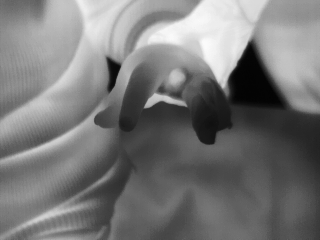

In [ ]:
thermal_image = cv2.imread(thermal_image, cv2.IMREAD_GRAYSCALE)
thermal_image

In [ ]:
therm = pd.read_csv('/content/thermal.csv')

In [ ]:
min_temp = float(therm.columns[0].split(';')[1])
max_temp = float(therm.columns[0].split(';')[3])

In [ ]:
temperature_image = min_temp + (thermal_image / 255.0) * (max_temp - min_temp)

In [ ]:
np.max(temperature_image), np.min(temperature_image)

(37.74901960784314, 22.12549019607843)

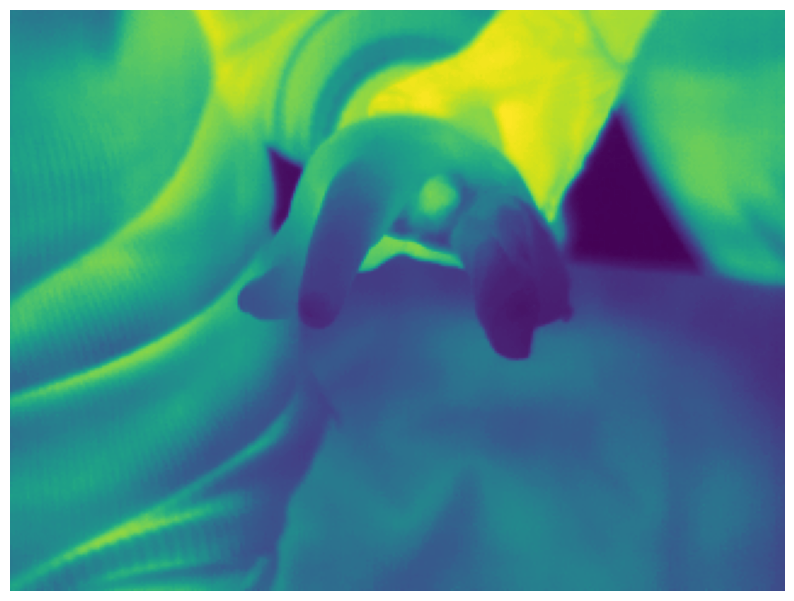

In [ ]:
show_img(temperature_image)